In [1]:
import pandas as pd
import numpy as np
%pylab inline
from xml.etree import ElementTree as ET
import os
import SimpleITK as sitk

Populating the interactive namespace from numpy and matplotlib


In [2]:
def convert_loc_to_ix(coords, origin, spacing):
    return np.absolute(coords - origin) / spacing

df_meta=  pd.read_csv(r'E:\lung\luna_metadata.csv')
dfann = pd.read_csv(r'E:\lung\LUNA\CSVFILES\annotations.csv')
dfann = pd.merge(left=dfann, right=df_meta, how='left', on='seriesuid')
dfann['Xnpy'] = dfann.apply(lambda x: convert_loc_to_ix(x['coordX'],x['Xorig'],x['Xspac']),1)
dfann['Ynpy'] = dfann.apply(lambda x: convert_loc_to_ix(x['coordY'],x['Yorig'],x['Yspac']),1)
dfann['Znpy'] = dfann.apply(lambda x: convert_loc_to_ix(x['coordZ'],x['Zorig'],x['Zspac']),1)

df_list = pd.read_csv(r"C:\Users\Daniel\Downloads\list3.2.csv")

def get_nodule_aliases(row):
    s = set([row['nodIDs'], row['Unnamed: 10'], row['Unnamed: 11'], row['Unnamed: 12'], row['Unnamed: 13'], row['Unnamed: 14'],
           row['Unnamed: 15']])
    if np.nan in s: 
        s.remove(np.nan)
    return s

df_list['aliases'] = df_list.apply(get_nodule_aliases, 1)
df_list.drop(['Unnamed: 8', 'nodIDs', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15'],inplace=True,axis=1)

dfresults = pd.read_csv(r"E:\lung\LIDC\results.csv")
dfresults['patient_id'] = dfresults['paths'].apply(lambda path: os.path.split(os.path.dirname(os.path.dirname(os.path.dirname(path))))[1])
dfresults['patient_id'] = dfresults['patient_id'].apply(lambda x: x.split('-')[2])

#dfresults['series_uid'] = dfresults['xmls'].apply(get_uid)
dfresults['series_uid'] = dfresults['paths'].apply(lambda path: os.path.split(os.path.dirname(path))[1])

def get_nodule_infos(xml, seriesuid):
    
    tree = ET.fromstring(xml.lower())
    sessions = tree.findall('{http://www.nih.gov}readingsession')
    nodule_data = {}
    for session in sessions:
        for nodule in session.findall('{http://www.nih.gov}unblindedreadnodule'):
            assert len(nodule.findall('{http://www.nih.gov}noduleid')) == 1, 'multiple ids per nodule ' + seriesuid
            nod_id = nodule.find('{http://www.nih.gov}noduleid').text
            if nod_id in nodule_data:
                #there is an ambiguous nodule
                #just pick one...
                subdata = nodule_data[nod_id]
                print 'duplicate nodule id', seriesuid, nod_id
                
            #assert nod_id not in nodule_data, 'duplicate node ids ' + seriesuid + ' ' + nod_id
            chars = nodule.findall('{http://www.nih.gov}characteristics')
            assert len(chars) <= 1, 'multiple chars per nodule ' + seriesuid
            if len(chars) == 0:
                continue
            chars = chars[0]
            subdata = {}

            for c in chars:
                subdata[c.tag.replace('{http://www.nih.gov}','')] = c.text
            nodule_data[nod_id] = subdata
    return nodule_data

dfresults['nodule_infos_parsed'] =dfresults.apply(lambda x: get_nodule_infos(x['xmls'], x['series_uid']),1)

duplicate nodule id 1.3.6.1.4.1.14519.5.2.1.6279.6001.137375498893536422914241295628 nodule 002
duplicate nodule id 1.3.6.1.4.1.14519.5.2.1.6279.6001.137375498893536422914241295628 0


In [3]:
def combine_metadatas(data):
    assert type(data) == list
    assert len(data) > 0
    assert type(data[0]) == dict
    subtletys = [int(d['subtlety']) for d in data]
    istructures = [int(d['internalstructure']) for d in data]
    calcifs = [int(d['calcification']) for d in data]
    sphericitys = [int(d['sphericity']) for d in data]
    margins = [int(d['margin']) for d in data]
    lobulations = [int(d['lobulation']) for d in data]
    spiculations = [int(d['spiculation']) for d in data]
    textures = [int(d['texture']) for d in data]
    malignancys = [int(d['malignancy']) for d in data]
    
    #numerics get an average
    subtlety = np.mean(subtletys) #average, it's numeric
    margin = np.mean(margins) #numeric
    lobulation = np.mean(lobulations)
    spiculation = np.mean(spiculations)
    malignancy = np.mean(malignancys)
    
    #categories get a percentage
    internal_structure = np.zeros(4)
    for i in istructures:
        internal_structure[i-1] += 1.0
    internal_structure /= internal_structure.sum()
    
    calcification = np.zeros(6)
    for i in calcifs:
        calcification[i-1] += 1.0
    calcification /= calcification.sum()
    
    sphericity = np.zeros(3)
    for i in sphericitys:
        sphericity[(i-1) / 2] += 1.0
    sphericity /= sphericity.sum()
    
    texture = np.zeros(3)
    for i in textures:
        texture[(i-1) / 2] += 1.0
    texture /= texture.sum()
    
    return [subtlety, internal_structure, calcification, sphericity, margin, lobulation, spiculation, texture, malignancy]

In [4]:
dfann['characteristics'] = np.nan

In [5]:
def get_nodule_metadata(uid, dfann, dfxml, dflist):
    #there are 13 duplicated uids in the dfxml
    #there are a lot in the annotation data.
    #we need to match each annotation to a metadata if possible
    DISTANCE_THRESHOLD=6
    DIAM_THRESHOLD = .15 #relative
    
    annotations = dfann[dfann['seriesuid'] == uid]
    #annotations['nodule_characteristics'] = []
    nodule_details = dfxml[dfxml['series_uid'] == uid]
    #the XML dataset has the mapping from uid to patient number. this we'll need
    patient_no = nodule_details['patient_id'].values[0]
    print 'patient num', patient_no
    #df list is indexed by patient number
    list_entries = dflist[dflist['case'] == int(patient_no)]
    #now let's go through each annotation and find the nearest nodule in the list entries
    mapped_results = []
    for i in range(annotations.shape[0]):
        row = annotations.iloc[i]
        
        ann_loc = np.array([row['Xnpy'], row['Ynpy']])
        ann_diam = row['diameter_mm']
        #print 'ann loc', ann_loc
        dists = []
        all_aliases = []
        size_diffs = []
        for _,list_entry in list_entries.iterrows():
            entry_loc = np.array([list_entry['x loc.'], list_entry['y loc.']])
            #print 'entry_loc', entry_loc
            dists.append( np.sum(abs(ann_loc - entry_loc)) )
            all_aliases.append(list_entry['aliases'])
            size_diffs.append( abs(1 - (list_entry['eq. diam.'] / ann_diam)) )
            #print 'dist', dists[-1], 'size diff', size_diffs[-1]
        #find closest
        if len(dists) == 0:
            #missing data.
            print 'missing list data for', patient_no
            mapped_results.append([])
            continue
        min_ix = np.argmin(dists)
        #if less than threshold, assume match
        if dists[min_ix] < DISTANCE_THRESHOLD and size_diffs[min_ix] < DIAM_THRESHOLD:
            #we did it.
            #now that we know the nodule aliases, go get them from the xml
            aliases = set( a.lower() for a in all_aliases[min_ix])
            print 'dist xy', dists[min_ix], 'sizedelta', size_diffs[min_ix], 'aliases', aliases
            #now look up each of these in the xml
            characteristics = []
            for _,xmlrow  in nodule_details.iterrows():
                parsed = xmlrow['nodule_infos_parsed']
                #print 'parsed', parsed
                for node_id, node_chars in parsed.iteritems():
                    if node_id in aliases:
                        #print 'adding node id', node_id
                        characteristics.append(node_chars)
                    #else:
                        #print 'not adding node id', node_id
                        
            aggregate_characteristics = combine_metadatas(characteristics)
            #print 'agg metadata', aggregate_characteristics
            #annotations.iloc[i, 'nodule_characteristics'] = aggregate_characteristics
            mapped_results.append(aggregate_characteristics)
        else:
            print 'unable to map annotation','dist xy', dists[min_ix], 'sizedelta', size_diffs[min_ix]
            mapped_results.append([])
            
    assert len(mapped_results) == annotations.shape[0]
    annotations['characteristics'] = mapped_results
    return annotations
    #return mapped_results

In [6]:
dfsubs = []
for uid in dfann['seriesuid'].unique():
    dfsubs.append(get_nodule_metadata(uid,
                   dfann, dfresults, df_list))
    
dfann_mapped = pd.concat(dfsubs)

patient num 1001
dist xy 0.477500741818 sizedelta 0.00292479003565 aliases set(['0', '2141', '22127', 'nodule 001'])
dist xy 0.571064707879 sizedelta 0.0436223043149 aliases set(['nodule 003', '22134', '2148'])
patient num 0813
dist xy 0.533765024 sizedelta 0.0372691364107 aliases set(['mi014_8002', '3', 'nodule 003'])
patient num 1002
dist xy 0.551611850105 sizedelta 0.0226860346863 aliases set(['0', '1632', 'nodule 004', '5158'])
dist xy 0.253869869811 sizedelta 0.00759497929258 aliases set(['5162', '2', 'nodule 003', '1636'])
dist xy 0.33114825207 sizedelta 0.00946970120929 aliases set(['1645', '5171', 'nodule 002', '4'])
dist xy 0.664318625684 sizedelta 0.00172613595332 aliases set(['1653', '3', '5175', 'nodule 001'])
patient num 0182
dist xy 0.797318172444 sizedelta 0.0572575281996 aliases set(['0', '162753', '160393', 'nodule 002'])


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


patient num 0187
dist xy 0.228861137455 sizedelta 0.012499923997 aliases set(['0', '162958', 'nodule 003', '160495'])
patient num 0766
dist xy 0.634351043765 sizedelta 0.0183593323251 aliases set(['0', '10717', 'nodule 001', '87247'])
patient num 0114
dist xy 0.698775948501 sizedelta 0.00797736591022 aliases set(['mi014_17687', '5', 'il057_167386', 'nodule 001'])
patient num 0236
dist xy 0.859837304 sizedelta 0.0278358387443 aliases set(['0', '184217', '171373', 'nodule 001'])
patient num 0278
dist xy 0.364998848 sizedelta 0.00183445543621 aliases set(['1', '171380', '168097', 'nodule 002'])
dist xy 0.6244587136 sizedelta 0.00713556723141 aliases set(['171383', 'nodule 004', '168098'])
patient num 0184
dist xy 0.4453500032 sizedelta 0.015573910161 aliases set(['1', '160663', '163136', 'nodule 002'])
patient num 0965
dist xy 1.12139580632 sizedelta 0.00580084262026 aliases set(['5230', '0', 'nodule 001', '1574'])
patient num 0890
dist xy 0.522807388262 sizedelta 0.00666972213596 aliases

In [36]:
df.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,Xorig,Yorig,Zorig,Xspac,Yspac,Zspac,Xnpy,Ynpy,Znpy,characteristics
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,-170.687500,-309.687500,716.7,0.625000,0.625000,1.8,384.522428,269.988663,88.708056,"[3.33333333333, [1.0, 0.0, 0.0, 0.0], [0.0, 0...."
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,-120.049467,9.480416,-657.0,0.556641,0.556641,1.0,172.527190,328.078802,265.918724,"[4.5, [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,-120.049467,9.480416,-657.0,0.556641,0.556641,1.0,220.054032,292.800162,251.506268,"[5.0, [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."
5,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,90.931713,149.027266,-426.544715,18.208570,-120.049467,9.480416,-657.0,0.556641,0.556641,1.0,379.025840,250.694691,230.455285,"[5.0, [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."
6,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,89.540769,196.405159,-515.073322,16.381276,-120.049467,9.480416,-657.0,0.556641,0.556641,1.0,376.527020,335.808662,141.926678,"[4.75, [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0..."


In [34]:
dfann_mapped = dfann_mapped[dfann_mapped['characteristics'].apply(lambda x: len(x)) == 9]

In [35]:
df = dfann_mapped

In [37]:
df['c'] = df['characteristics']

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [38]:
df['subtlety'] = df['c'].apply(lambda x: x[0])
df['internal_structure'] = df['c'].apply(lambda x: x[1])
df['calcification'] = df['c'].apply(lambda x: x[2])
df['sphericity'] = df['c'].apply(lambda x: x[3])
df['margin'] = df['c'].apply(lambda x: x[4])
df['lobulation'] = df['c'].apply(lambda x: x[5])
df['spiculation'] = df['c'].apply(lambda x: x[6])
df['texture'] = df['c'].apply(lambda x: x[7])
df['malignancy'] = df['c'].apply(lambda x: x[8])



C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

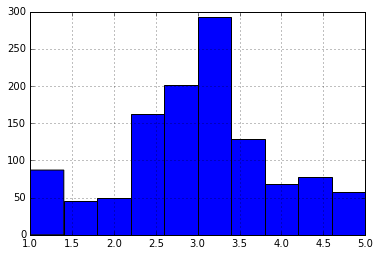

In [46]:
df['malignancy'].hist(bins=10); show()

In [95]:
np.corrcoef(np.log(-3+df['diameter_mm']), df['malignancy'])

array([[ 1.        ,  0.64160593],
       [ 0.64160593,  1.        ]])

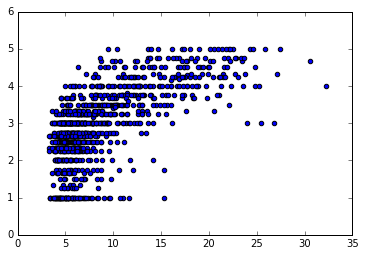

In [96]:
scatter(df['diameter_mm'], df['malignancy'])

In [117]:
np.corrcoef(df['texture'].apply(lambda x: x[1]), df['malignancy'])

array([[ 1.        ,  0.26336369],
       [ 0.26336369,  1.        ]])

In [226]:
Xnumeric = df[['diameter_mm', 'subtlety', 'margin', 'lobulation', 'spiculation']].values
Ymalig = df['malignancy'].values

from sklearn.linear_model import LogisticRegression

In [156]:
Xcat = np.zeros((df.shape[0], 4+6+3+3))
Xcat[:,0] = df['internal_structure'].apply(lambda x: x[0]).values
Xcat[:,1] = df['internal_structure'].apply(lambda x: x[1]).values
Xcat[:,2] = df['internal_structure'].apply(lambda x: x[2]).values
Xcat[:,3] = df['internal_structure'].apply(lambda x: x[3]).values
Xcat[:,4] = df['calcification'].apply(lambda x: x[0]).values
Xcat[:,5] = df['calcification'].apply(lambda x: x[1]).values
Xcat[:,6] = df['calcification'].apply(lambda x: x[2]).values
Xcat[:,7] = df['calcification'].apply(lambda x: x[3]).values
Xcat[:,8] = df['calcification'].apply(lambda x: x[4]).values
Xcat[:,9] = df['calcification'].apply(lambda x: x[5]).values
Xcat[:,10] = df['sphericity'].apply(lambda x: x[0]).values
Xcat[:,11] = df['sphericity'].apply(lambda x: x[1]).values
Xcat[:,12] = df['sphericity'].apply(lambda x: x[2]).values
Xcat[:,13] = df['texture'].apply(lambda x: x[0]).values
Xcat[:,14] = df['texture'].apply(lambda x: x[1]).values
Xcat[:,15] = df['texture'].apply(lambda x: x[2]).values


In [ ]:
from sklearn.linear_model import 

In [223]:
Xnumeric = df[['diameter_mm']].values
#Ymalig = df['malignancy'].values
Y = np.zeros((df.shape[0],6))

Y[:,0] = df['calcification'].apply(lambda x: x[0]).values
Y[:,1] = df['calcification'].apply(lambda x: x[1]).values
Y[:,2] = df['calcification'].apply(lambda x: x[2]).values
Y[:,3] = df['calcification'].apply(lambda x: x[3]).values
Y[:,4] = df['calcification'].apply(lambda x: x[4]).values
Y[:,5] = df['calcification'].apply(lambda x: x[5]).values

# Y[:,0] = df['sphericity'].apply(lambda x: x[0]).values
# Y[:,1] = df['sphericity'].apply(lambda x: x[1]).values
# Y[:,2] = df['sphericity'].apply(lambda x: x[2]).values

# Y[:,0] = df['texture'].apply(lambda x: x[0]).values
# Y[:,1] = df['texture'].apply(lambda x: x[1]).values
# Y[:,2] = df['texture'].apply(lambda x: x[2]).values

# Y[:,0] = df['internal_structure'].apply(lambda x: x[0]).values
# Y[:,1] = df['internal_structure'].apply(lambda x: x[1]).values
# Y[:,2] = df['internal_structure'].apply(lambda x: x[2]).values
# Y[:,3] = df['internal_structure'].apply(lambda x: x[3]).values

Yt = np.argmax(Y, axis=1)
lr = LogisticRegression(C=1000).fit(Xnumeric, Yt)
print lr.score(Xnumeric, Yt)
from sklearn.linear_model import Ridge
#from sklearn.metrics import 
ridge = Ridge(alpha=.0001).fit(Y,Xnumeric.ravel())
print ridge.score(Y,Xnumeric.ravel())

0.88566552901
0.0304936330008


In [232]:
Y[Yt == 0,0] = 1

In [233]:
Y[Yt == 1,1:] = 0

In [207]:
np.set_printoptions(precision=4)
for i in Y.sum(axis=0):
    print i

92.15
186.554761905
893.295238095


In [193]:
Y[:,3].sum()

4.083333333333333

In [188]:
print Y[Y > 0]

[3 3 3]


In [180]:
lr = LogisticRegression(C=1).fit(Xnumeric, Ymalig > 3)
from sklearn.metrics import log_loss
print log_loss(Ymalig > 3, lr.predict_proba(Xnumeric))

0.367494452888


In [175]:
Yresid = (Ymalig > 3) - lr.predict_proba(Xnumeric)[:,1]

In [176]:
#see what is most predictive of residual


In [227]:
for i in range(Xnumeric.shape[1]):
    print i,np.corrcoef(Xnumeric[:,i],Xnumeric[:,0])[0,1]

0 1.0
1 0.542553339457
2 -0.141792970475
3 0.549995613446
4 0.553989240662


In [231]:
np.corrcoef(df['margin'], df['malignancy'])

array([[ 1. , -0.4],
       [-0.4,  1. ]])

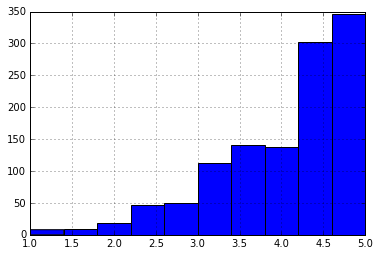

In [230]:
df['margin'].hist(bins=10); show()

In [157]:
lr = LogisticRegression(C=1).fit(Xcat, Ymalig > 3)
from sklearn.metrics import log_loss
print log_loss(Ymalig > 3, lr.predict_proba(Xcat))

0.597612050876


In [149]:
for i,c in enumerate(lr.coef_[0]):
    print i, c

0 -0.510468021333
1 -0.321192622926
2 -0.136589573222
3 0.9892273968
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0


In [133]:

Xcombined = np.hstack([Xnumeric, Xcat])
lr = LogisticRegression(C=1).fit(Xcombined, Ymalig > 4)

from sklearn.metrics import log_loss
print log_loss(Ymalig > 4, lr.predict_proba(Xcombined))

0.143741440656


In [101]:
df.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,Xorig,Yorig,Zorig,Xspac,Yspac,...,Znpy,subtlety,internal_structure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,-170.687500,-309.687500,716.7,0.625000,0.625000,...,88.708056,3.333333,"[1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]",3.666667,1.333333,1.333333,"[0.0, 0.0, 1.0]",2.666667
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,-120.049467,9.480416,-657.0,0.556641,0.556641,...,265.918724,4.500000,"[1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]",4.750000,1.750000,1.500000,"[0.0, 0.0, 1.0]",3.750000
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,-120.049467,9.480416,-657.0,0.556641,0.556641,...,251.506268,5.000000,"[1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.25, 0.75]",4.750000,1.750000,1.500000,"[0.0, 0.0, 1.0]",4.250000
5,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,90.931713,149.027266,-426.544715,18.208570,-120.049467,9.480416,-657.0,0.556641,0.556641,...,230.455285,5.000000,"[1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.5, 0.5]",5.000000,1.750000,1.250000,"[0.0, 0.0, 1.0]",3.750000
6,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,89.540769,196.405159,-515.073322,16.381276,-120.049467,9.480416,-657.0,0.556641,0.556641,...,141.926678,4.750000,"[1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.25, 0.75]",4.250000,1.500000,1.500000,"[0.0, 0.5, 0.5]",3.750000


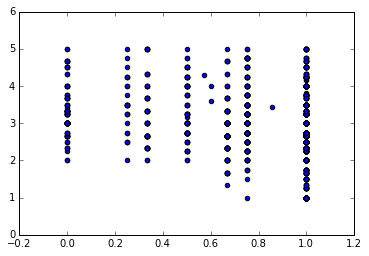

In [87]:
scatter(df['texture'].apply(lambda x: x[2]), df['malignancy'])

In [48]:
df = df.drop(['characteristics', 'c'],axis=1)

In [49]:
df.to_csv('annotations_enhanced.csv',index=False)

In [33]:
temp.shape

(1172, 15)

In [23]:
temp = dfann_mapped[dfann_mapped['characteristics'].apply(lambda x: len(x)) < 9]

In [ ]:

dfann_mapped['internal_structure'] = dfann_mapped['characteristics'].apply()

In [7]:
dfann_mapped.to_csv('annotations_mapped2.csv',index=False)

In [392]:
get_nodule_metadata('1.3.6.1.4.1.14519.5.2.1.6279.6001.882070241245008756731854510592',
                   dfann, dfresults, df_list)

patient num 0018
dist xy 0.700082866558 sizedelta 0.020074346897 aliases set(['0', 'nodule 004', 'il057_128328'])
dist xy 0.101602662704 sizedelta 0.00634965086387 aliases set(['1', 'mi014_11928', 'il057_123112', 'nodule 001'])
dist xy 0.451983824933 sizedelta 0.0187765337554 aliases set(['il057_128327', '2', 'nodule 003'])
dist xy 0.73825573672 sizedelta 0.0168544975517 aliases set(['il057_123109', 'mi014_11912', '3', 'nodule 002'])


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,seriesuid,coordX,coordY,coordZ,diameter_mm,Xorig,Yorig,Zorig,Xspac,Yspac,Zspac,Xnpy,Ynpy,Znpy,characteristics
1127,1.3.6.1.4.1.14519.5.2.1.6279.6001.882070241245...,-98.792710,25.940844,-170.220324,5.414311,-158.800003,-170.0,-321.309998,0.664062,0.664062,2.5,90.363989,295.064071,60.435870,"[2.66666666667, [1.0, 0.0, 0.0, 0.0], [0.0, 0...."
1128,1.3.6.1.4.1.14519.5.2.1.6279.6001.882070241245...,132.719044,16.664718,-130.308718,10.438279,-158.800003,-170.0,-321.309998,0.664062,0.664062,2.5,438.993703,281.095306,76.400512,"[4.25, [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.25, ..."
1129,1.3.6.1.4.1.14519.5.2.1.6279.6001.882070241245...,92.920052,-18.998324,-120.019035,6.500935,-158.800003,-170.0,-321.309998,0.664062,0.664062,2.5,379.061061,227.390923,80.516385,"[3.0, [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."
1130,1.3.6.1.4.1.14519.5.2.1.6279.6001.882070241245...,83.223318,36.044730,-47.980245,16.945394,-158.800003,-170.0,-321.309998,0.664062,0.664062,2.5,364.458910,310.279346,109.331901,"[5.0, [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."


In [375]:
dfann[dfann['seriesuid'] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.329404588567903628160652715124']

,seriesuid,coordX,coordY,coordZ,diameter_mm,Xorig,Yorig,Zorig,Xspac,Yspac,Zspac,Xnpy,Ynpy,Znpy
926,1.3.6.1.4.1.14519.5.2.1.6279.6001.329404588567...,29.808965,60.467953,-278.367696,6.955440,-211.199997,-200.0,-380.75,0.78125,0.78125,2.5,308.491471,333.398979,40.952921
927,1.3.6.1.4.1.14519.5.2.1.6279.6001.329404588567...,36.079721,-29.736083,-89.480536,23.043448,-211.199997,-200.0,-380.75,0.78125,0.78125,2.5,316.518039,217.937814,116.507786


In [303]:
dfresults['series_uid'].value_counts()

1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301    6
1.3.6.1.4.1.14519.5.2.1.6279.6001.272123398257168239653655006815    4
1.3.6.1.4.1.14519.5.2.1.6279.6001.855232435861303786204450738044    3
1.3.6.1.4.1.14519.5.2.1.6279.6001.550599855064600241623943717588    3
1.3.6.1.4.1.14519.5.2.1.6279.6001.229343399861261429237689489892    2
1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.240630002689062442926543993263    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.187108608022306504546286626125    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.235381170872316280538332229850    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.266462563888243192390432002410    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.801945620899034889998809817499    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.404768898286087278137462774930    1
1.3.6.1.4.1.14519.5.

In [302]:
dfresults.head()

,Unnamed: 0,paths,xmls,series_uid,patient_id,seriesuid2,nodule_infos_parsed
1,1,C:\Users\DHammack\Desktop\lidc\DOI\LIDC-IDRI-0...,"<?xml version=""1.0"" encoding=""UTF-8""?>\r\n<Lid...",1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,"{u'0': {u'spiculation': u'5', u'sphericity': u..."
3,3,C:\Users\DHammack\Desktop\lidc\DOI\LIDC-IDRI-0...,"<?xml version=""1.0"" encoding=""UTF-8""?>\r\n<Lid...",1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,0002,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,"{u'8': {u'spiculation': u'1', u'sphericity': u..."
4,4,C:\Users\DHammack\Desktop\lidc\DOI\LIDC-IDRI-0...,"<?xml version=""1.0"" encoding=""UTF-8""?>\r\n<Lid...",1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,0003,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,"{u'mi014_16599': {u'spiculation': u'2', u'sphe..."
6,6,C:\Users\DHammack\Desktop\lidc\DOI\LIDC-IDRI-0...,"<?xml version=""1.0"" encoding=""UTF-8""?>\r\n<Lid...",1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620...,0004,1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620...,"{u'mi014_16178': {u'spiculation': u'1', u'sphe..."
8,8,C:\Users\DHammack\Desktop\lidc\DOI\LIDC-IDRI-0...,"<?xml version=""1.0"" encoding=""UTF-8""?>\r\n<Lid...",1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048...,0005,1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048...,"{u'mi014_11888': {u'spiculation': u'1', u'sphe..."


In [296]:
df_list.head()

,case,scan,roi,volume,eq. diam.,x loc.,y loc.,slice no.,aliases
0,1,3000566,1,6459.75,23.107,317,367,43,"{0, MI014_12127, IL057_127364, Nodule 001}"
1,2,3000522,1,6663.44,23.347,345,361,77,"{8, MI014_11691}"
2,3,3000611,1,408.79,9.208,308,198,57,"{IL057_130602, MI014_16599, Nodule 003, 8}"
3,3,3000611,2,1165.82,13.058,221,219,56,"{9, IL057_130598, Nodule 002, MI014_16595}"
4,3,3000611,3,4989.64,21.201,367,350,65,"{0, IL057_130591, MI014_16588, Nodule 001}"


In [294]:
dfresults.shape[0] - len(dfresults['series_uid'].unique())

13

In [291]:
dfresults

,Unnamed: 0,paths,xmls,series_uid,patient_id,seriesuid2,nodule_infos_parsed
1,1,C:\Users\DHammack\Desktop\lidc\DOI\LIDC-IDRI-0...,"<?xml version=""1.0"" encoding=""UTF-8""?>\r\n<Lid...",1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,"{u'0': {u'spiculation': u'5', u'sphericity': u..."
3,3,C:\Users\DHammack\Desktop\lidc\DOI\LIDC-IDRI-0...,"<?xml version=""1.0"" encoding=""UTF-8""?>\r\n<Lid...",1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,0002,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,"{u'8': {u'spiculation': u'1', u'sphericity': u..."
4,4,C:\Users\DHammack\Desktop\lidc\DOI\LIDC-IDRI-0...,"<?xml version=""1.0"" encoding=""UTF-8""?>\r\n<Lid...",1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,0003,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,"{u'mi014_16599': {u'spiculation': u'2', u'sphe..."
6,6,C:\Users\DHammack\Desktop\lidc\DOI\LIDC-IDRI-0...,"<?xml version=""1.0"" encoding=""UTF-8""?>\r\n<Lid...",1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620...,0004,1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620...,"{u'mi014_16178': {u'spiculation': u'1', u'sphe..."
8,8,C:\Users\DHammack\Desktop\lidc\DOI\LIDC-IDRI-0...,"<?xml version=""1.0"" encoding=""UTF-8""?>\r\n<Lid...",1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048...,0005,1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048...,"{u'mi014_11888': {u'spiculation': u'1', u'sphe..."
10,10,C:\Users\DHammack\Desktop\lidc\DOI\LIDC-IDRI-0...,"<?xml version=""1.0"" encoding=""UTF-8""?>\r\n<Lid...",1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896...,0006,1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896...,"{u'il057_127072': {u'spiculation': u'1', u'sph..."
13,13,C:\Users\DHammack\Desktop\lidc\DOI\LIDC-IDRI-0...,"<?xml version=""1.0"" encoding=""UTF-8""?>\r\n<Lid...",1.3.6.1.4.1.14519.5.2.1.6279.6001.272348349298...,0007,1.3.6.1.4.1.14519.5.2.1.6279.6001.272348349298...,"{u'mi014_19564': {u'spiculation': u'5', u'sphe..."
14,14,C:\Users\DHammack\Desktop\lidc\DOI\LIDC-IDRI-0...,"<?xml version=""1.0"" encoding=""UTF-8""?>\r\n<Lid...",1.3.6.1.4.1.14519.5.2.1.6279.6001.774060103415...,0008,1.3.6.1.4.1.14519.5.2.1.6279.6001.774060103415...,"{u'mi014_11909': {u'spiculation': u'1', u'sphe..."
17,17,C:\Users\DHammack\Desktop\lidc\DOI\LIDC-IDRI-0...,"<?xml version=""1.0"" encoding=""UTF-8""?>\r\n<Lid...",1.3.6.1.4.1.14519.5.2.1.6279.6001.286061375572...,0009,1.3.6.1.4.1.14519.5.2.1.6279.6001.286061375572...,"{u'nodule 002': {u'spiculation': u'1', u'spher..."
18,18,C:\Users\DHammack\Desktop\lidc\DOI\LIDC-IDRI-0...,"<?xml version=""1.0"" encoding=""UTF-8""?>\r\n<Lid...",1.3.6.1.4.1.14519.5.2.1.6279.6001.416701701108...,0010,1.3.6.1.4.1.14519.5.2.1.6279.6001.416701701108...,"{u'0': {u'spiculation': u'1', u'sphericity': u..."


# Correlation to diameter #